In [16]:
import importlib
import porosity_functions
importlib.reload(porosity_functions)
from porosity_functions import *
from IPython.core.display import display, HTML
import pandas as pd
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def initialize_slice(img1, img2, x_img1 = 500, y_img1 = 1000, x_img2 =1500, y_img2 = 1000, slice_sq_dim = 224):
    
    x1_img1 = x_img1 - int( slice_sq_dim / 2 )
    y1_img1 = y_img1 - int( slice_sq_dim / 2 ) 
    x2_img1 = x_img1 + int( slice_sq_dim / 2 )
    y2_img1 = y_img1 + int( slice_sq_dim / 2 )
    
    img1_slice = img1[y1_img1:y2_img1, x1_img1:x2_img1]
    
    x1_img2 = x_img2 - int( slice_sq_dim / 2 )
    y1_img2 = y_img2 - int( slice_sq_dim / 2 ) 
    x2_img2 = x_img2 + int( slice_sq_dim / 2 )
    y2_img2 = y_img2 + int( slice_sq_dim / 2 )
    
    img2_slice = img2[y1_img2:y2_img2, x1_img2:x2_img2]
    
    return img1_slice, img2_slice

In [3]:
curr_dir = os.getcwd()
image_dir = os.path.join(curr_dir, "Images")
img500_orig = cv2.imread(os.path.join(image_dir, "500Ximage.tif"), cv2.IMREAD_UNCHANGED)
img2000_orig = cv2.imread(os.path.join(image_dir, "2000Ximage.tif"), cv2.IMREAD_UNCHANGED)
ret500, img500_th = cv2.threshold(img500_orig, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret2000, img2000_th = cv2.threshold(img2000_orig, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [4]:
img_slice500, img_slice2000 = initialize_slice(img500_orig, img2000_orig)
ret500slice, img_slice500_th = cv2.threshold(img_slice500, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret2000slice, img_slice2000_th = cv2.threshold(img_slice2000, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# Image.fromarray(img_slice_orig).save(path_img_slice_orig)

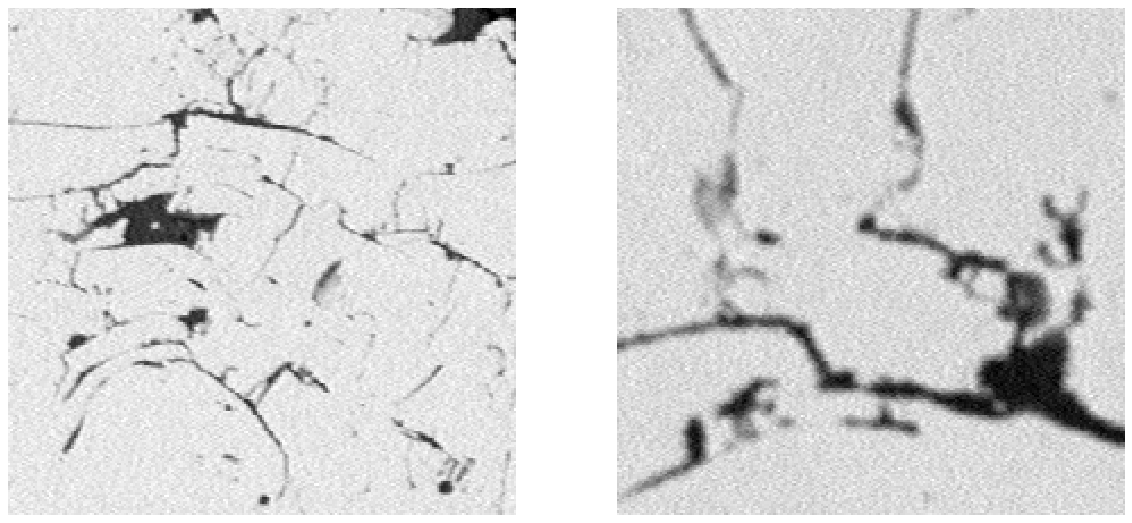

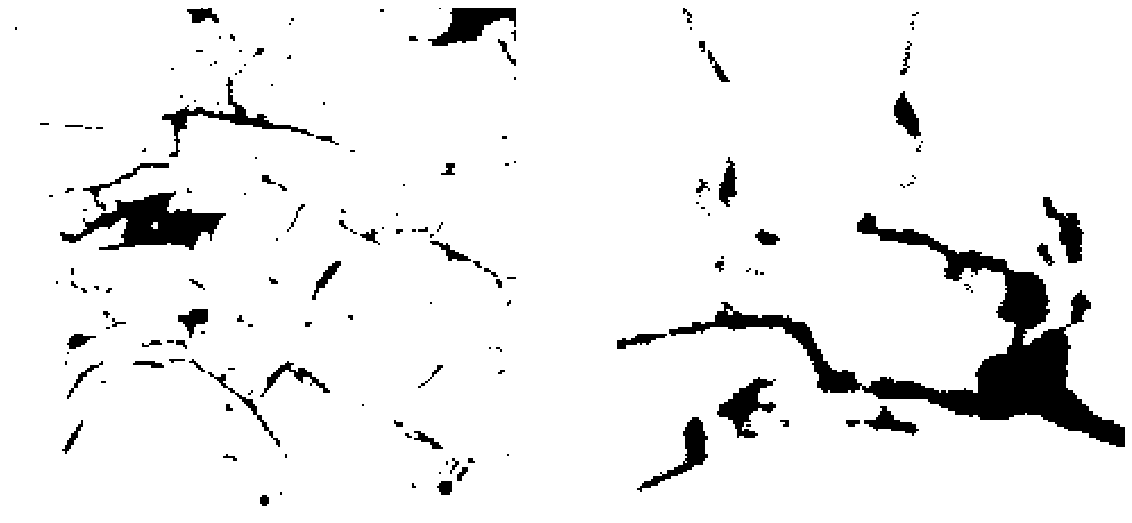

In [5]:
view2_image(img_slice500, img_slice2000)
view2_image(img_slice500_th, img_slice2000_th)

In [ ]:
# Image.fromarray(img_slice500).save(os.path.join(image_dir,"img_slice500.tif"))
# Image.fromarray(img_slice2000).save(os.path.join(image_dir,"img_slice2000.tif"))
# Image.fromarray(img_slice500_th).save(os.path.join(image_dir,"img_slice500_th.tif"))
# Image.fromarray(img_slice2000_th).save(os.path.join(image_dir,"img_slice2000_th.tif"))

In [6]:
class pixel_block():
    def __init__(self, parent=None):
        self.orig_image = []
        self.shape_cluster = [] 
        self.cluster_bounds = []
        self.NN_List = []
        self.img = []
        self.img_shape = []
        self.pos_i = 0 
        self.pos_j = 0     
        self.thread_cluster = []
        self.show_cluster = False
        
   # function that gets noisy image based on a noise threshold (the minimum difference in adjacent pixel values that creates a noise point with ref_th value)
    def get_noisy_image(self, img_trial, ref_th, noise_thresh = 50):
        kernel_col = np.zeros(img_trial.shape[1], dtype=int)
        kernal_row = np.zeros(img_trial.shape[0], dtype=int)
        img_trial_noisy = np.copy(img_trial)
        
        for i in range(0, img_trial.shape[0]):
            for j in range(0, img_trial.shape[1]): 
                kernel_col[j] = self.orig_image[i][j]   
                
            kernel_col_maxima_check = np.r_[True, (kernel_col[:-1] - kernel_col[1:]) > noise_thresh] & np.r_[(kernel_col[1:] - kernel_col[:-1]) > noise_thresh, True]      
            for k in range(0, kernel_col_maxima_check.shape[0]):
                if kernel_col_maxima_check[k]:
                    img_trial_noisy[i][k] = ref_th
                    
        for j in range(0, img_trial.shape[1]):
            for i in range(0, img_trial.shape[0]): 
                kernal_row[i] = self.orig_image[i][j]
                
            kernel_row_maxima_check = np.r_[True, (kernal_row[:-1] - kernal_row[1:]) > noise_thresh ] & np.r_[(kernal_row[1:] - kernal_row[:-1]) > noise_thresh , True]   
            for k in range(0, kernel_row_maxima_check.shape[0]):
                if kernel_row_maxima_check[k]:
                    img_trial_noisy[k][j] = ref_th
        
        return img_trial_noisy
         
        
    def view_closed_shape(self):
        self.img_shape = []      
        min_row = (min([i[0] for i in self.shape_cluster]))
        min_col = (min([i[1] for i in self.shape_cluster]))
        max_row = (max([i[0] for i in self.shape_cluster]))
        max_col = (max([i[1] for i in self.shape_cluster]))
        shape_cluster_orig = self.orig_image[min_row:max_row, min_col:max_col]
        shape_cluster_new = [(i[0]-min_row+1,i[1]-min_col+1) for i in self.shape_cluster]
        max_row = max_row - min_row
        max_col = max_col - min_col
        min_row = 0
        min_col = 0
        sq_diam = max(max_row, max_col) + 2
        canvas = np.full((sq_diam, sq_diam), 255)
        
        for coord in shape_cluster_new:
            canvas[coord] = 0
        
        print("area of cluster = ", self.count_pixel(canvas,0))
        view1_image(canvas)
    
    
    def get_cluster_iteration(self, img, pos_i, pos_j, new = True):
        if img[pos_i, pos_j] != 0:
            return 0
        
        if img[pos_i, pos_j] == 0 and new == True:
            self.img = img
            self.pos_i, self.pos_j = pos_i, pos_j
            neighbour = (self.pos_i, self.pos_j)
            self.shape_cluster.append(neighbour)
                 
        possible_pixels = get_nearest_neighbours(self.img, pos_i, pos_j, 1)

        for pixel in possible_pixels:
            if pixel in self.shape_cluster:
                continue

            if self.img[pixel[0], pixel[1]] == 0:
                self.shape_cluster.append(pixel)
                self.img[pixel[0], pixel[1]] = 1
                
                neighbour_list = get_nearest_neighbours(self.img, pixel[0], pixel[1], 1)
                for neighbour in neighbour_list:
                    possible_pixels.append(neighbour)                          
                
        if not self.shape_cluster:
            return 0
        else:
            if self.show_cluster:
                self.view_closed_shape()
            return 1    
      
    # counts the pixels of a specific color  
    def count_pixel(self, img, pixel_color): 
        count = 0
        for i in range(0, img.shape[0]):
            for j in range(0, img.shape[1]):
                if img[i,j] == pixel_color:
                    count = count + 1
                    
        return count
    
    def repeat_points_area(self, img, check_area):
        point_area_check = False
        if len(self.shape_cluster) < check_area:
            point_area_check = True
            for coord in self.shape_cluster:
                img[coord] = 0
                
        return point_area_check, img    
    
    

    def calc_min_distance(self, pos, max_row, max_col):
        horiz_plus = 1
        horiz_minus = 1
        vert_plus = 1
        vert_minus = 1
        max_thickness = 3

        while pos[1] + horiz_plus < max_col + 1:       
            if pos[1] + horiz_plus > self.img.shape[1]:
                break

            if self.img[pos[0], pos[1] + horiz_plus] == 255:
                break    

            horiz_plus = horiz_plus + 1

        while pos[1] - horiz_minus >= 0:
            if self.img[pos[0], pos[1] - horiz_minus] == 255:
                break   

            horiz_minus = horiz_minus + 1

        while pos[0] - vert_minus >= 0: 
            if self.img[pos[0] - vert_minus, pos[1]] == 255:
                break  

            vert_minus = vert_minus + 1

        while pos[0] + vert_plus < max_row + 1:
            if pos[0] + vert_plus > self.img.shape[0]:
                break

            if self.img[pos[0] + vert_plus, pos[1]] == 255:
                break

            vert_plus = vert_plus + 1

        vert_thickness = vert_plus + vert_minus
        horiz_thickness = horiz_plus + horiz_minus   
        thickness = min(horiz_thickness, vert_thickness)

        thickness_midpoint = False

        if thickness == horiz_thickness:
            if horiz_plus == horiz_minus and horiz_plus>1:
                thickness_midpoint = True

        if thickness == vert_thickness:
            if vert_plus == vert_minus and vert_plus > 1:
                thickness_midpoint = True

        if thickness < max_thickness:
            if thickness_midpoint is False:
                self.thread_cluster.append(pos)
                i = -1 * max_thickness
                while i < max_thickness:
                    if pos[1] + i < max_col: 
                        if self.img[pos[0], pos[1] + i] == 1:
                            self.thread_cluster.append((pos[0], pos[1] + i))
                    i += 1

                i = -1 * max_thickness
                while i < max_thickness:
                    if pos[0] + i < max_row: 
                        if self.img[pos[0] + i, pos[1]] == 1:
                            self.thread_cluster.append((pos[0] + i, pos[1]))
                    i += 1

    def connected_cluster_seggragation(self, img):
        self.thread_cluster = []
        thread_cluster_temp = []
        self.img = img
        max_row = 0
        max_col = 0
        for coord in self.shape_cluster:
            if self.img[coord] == 0:
                self.img[coord] = 1

            if coord[0] > max_row:
                max_row = coord[0]

            if coord[1] > max_col:
                max_col = coord[1]

        for coord in self.shape_cluster:
            self.calc_min_distance(coord, max_row, max_col)

        for coord in self.thread_cluster:
            mark_possibility_NN1 = False
            mark_possibility_NN2 = False
            possible_pixels = get_nearest_neighbours(self.img, coord[0], coord[1], 1)           
            for possible_cord in possible_pixels:
                if possible_cord in self.thread_cluster:
                    mark_possibility_NN1 = True

            if coord[0] > 0 and coord[1] > 0:
                possible_pixels = get_nearest_neighbours(self.img, coord[0]-1, coord[1]-1, 2)           
                for possible_cord in possible_pixels:
                    if possible_cord in self.thread_cluster:
                        mark_possibility_NN2 = True

            else:
                # Since the pixel is in the edge
                mark_possibility_NN2 = False

            # To check if the thread is atleast 3 pixels long
            if mark_possibility_NN1 is True and mark_possibility_NN2 is True:
                thread_cluster_temp.append(coord)

        if thread_cluster_temp:
            for elem in thread_cluster_temp:
                if self.img[elem] == 1:
                    self.img[elem] = 2

        self.thread_cluster = thread_cluster_temp
        return self.img


    def join_broken_threads(self, critical_area = 4):
        # Current cluster in focus is not a noise        
        if int(len(self.shape_cluster)) >= critical_area:
            for coord in self.shape_cluster:
                if coord[0] - 1 >= 0 and coord[1] - 1 >= 0:
                    pos_i = coord[0] - 1
                    pos_j = coord[1] - 1
                    possible_points = get_nearest_neighbours(self.img, pos_i, pos_j, 3)

                    for possible_coord in possible_points:
                        if (self.img[possible_coord] == 1 or self.img[possible_coord] == 0):
                            if possible_coord not in self.shape_cluster:
                                self.img = cv2.line(self.img, (coord[1], coord[0]), (possible_coord[1], possible_coord[0]), (2, 2, 2), thickness = 1, lineType=8)


            for coord in self.shape_cluster:
                if coord[0] - 2 >= 0 and coord[1] - 2 >= 0:
                    pos_i = coord[0] - 2
                    pos_j = coord[1] - 2
                    possible_points = get_nearest_neighbours(self.img, pos_i, pos_j, 5)
                    for possible_coord in possible_points:
                        if (self.img[possible_coord] == 1 or self.img[possible_coord] == 0):
                            if possible_coord not in self.shape_cluster:
                                self.img = cv2.line(self.img, (coord[1], coord[0]), (possible_coord[1], possible_coord[0]), (2, 2, 2), thickness = 1, lineType=8)

        self.img[self.img == 2] = 1
        return self.img 

In [109]:
# to scan and place a important point over areas that could be missed during global otsu
def porosity_operation0(img_slice_orig, ref_th):
    img_trial = np.copy(img_slice_orig)
    img_slice_orig_noisy = np.copy(img_slice_orig)
    block = pixel_block()
    block.orig_image = img_slice_orig
    slice_sq_dim = 224
    
    thresh_noise_array = []
    area_noise_array = []
    
    # Finding the noise added for each of threshold difference passed to the function
    # getting a distribution of noises added for noise threshold betwee 0 and 40 
    for val in range(40,0,-1):
        img_slice_orig_noisy = block.get_noisy_image(img_trial, ref_th, noise_thresh = val)
        area_added_noise = block.count_pixel(img_slice_orig_noisy, pixel_color = ref_th)
        thresh_noise_array.append(val)
        area_noise_array.append(area_added_noise)
        
    # adding limiting case of count of noise pixels as 4% of the total image area
    for i in range(len(area_noise_array)):
        save_val = thresh_noise_array[i]
        if area_noise_array[i] > (1/100)*(slice_sq_dim*slice_sq_dim):
            print("The maximum allowable noise level reached = ", save_val)
            break
            
    area_added_noise_before = block.count_pixel(img_trial, pixel_color = ref_th) 
    img_slice_orig_noisy = block.get_noisy_image(img_trial, ref_th, noise_thresh = save_val)
    area_added_noise_after = block.count_pixel(img_slice_orig_noisy, pixel_color = ref_th) 
    noise = area_added_noise_after - area_added_noise_before
    
    return img_slice_orig_noisy, noise

In [8]:
img_slice500_noisy, noise_added_500_slice = porosity_operation0(img_slice500, ret500slice)
img_slice2000_noisy, noise_added_2000_slice = porosity_operation0(img_slice2000, ret2000slice)

The maximum allowable noise level reached =  16
The maximum allowable noise level reached =  16


In [9]:
_, img_slice500_noisy_th = cv2.threshold(img_slice500_noisy, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
_, img_slice2000_noisy_th = cv2.threshold(img_slice2000_noisy, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [10]:
# Image.fromarray(img_slice500_noisy).save(os.path.join(image_dir,"img_slice500_noisy.tif"))
# Image.fromarray(img_slice2000_noisy).save(os.path.join(image_dir,"img_slice2000_noisy_noisy.tif"))
# Image.fromarray(img_slice500_noisy_th).save(os.path.join(image_dir,"img_slice500_noisy_th.tif"))
# Image.fromarray(img_slice2000_noisy_th).save(os.path.join(image_dir,"img_slice2000_noisy_th.tif"))

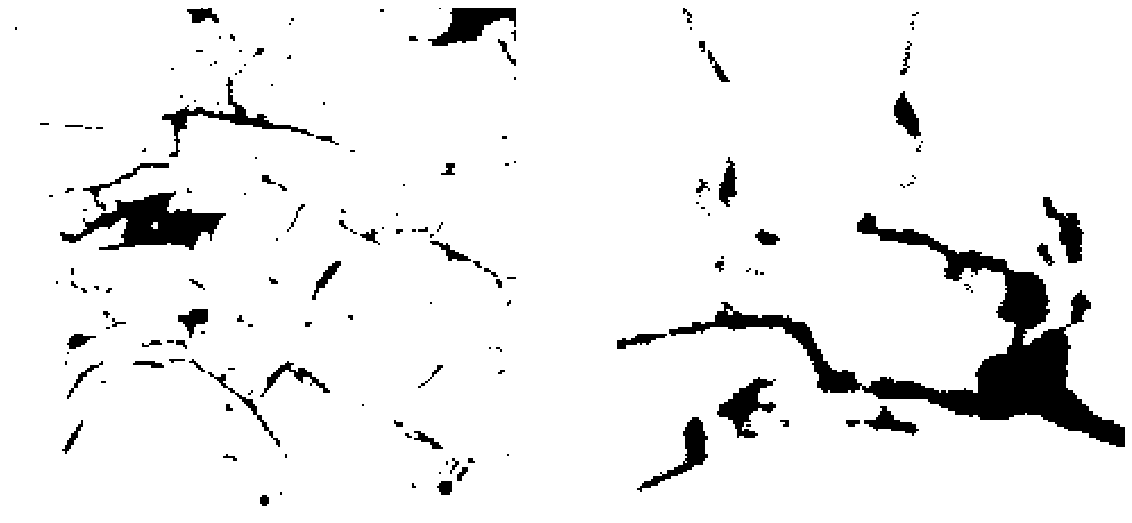

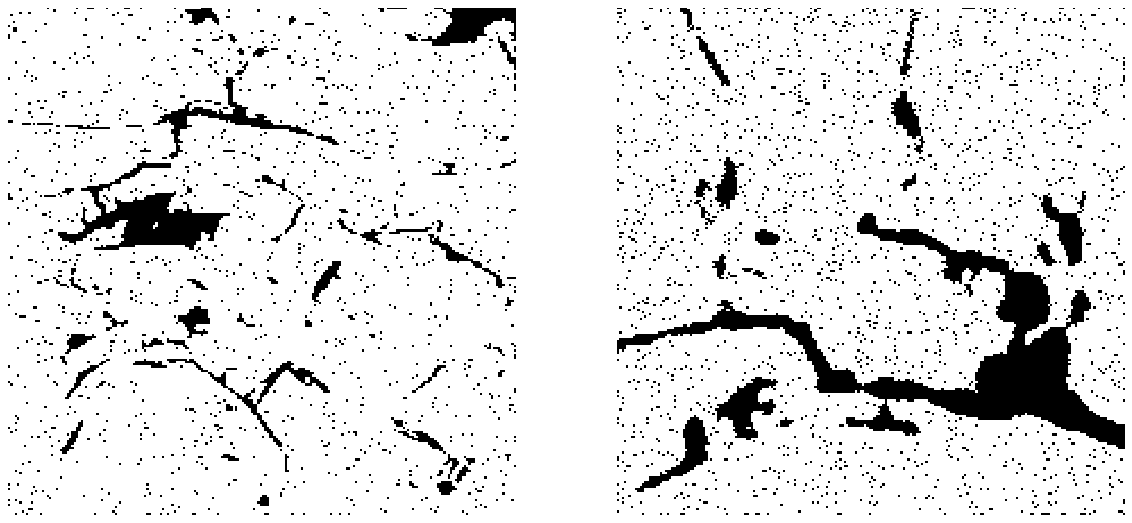

In [11]:
view2_image(img_slice500_th, img_slice2000_th)
view2_image(img_slice500_noisy_th, img_slice2000_noisy_th)

In [12]:
# To detect clusters, join points to closeby clusters/threads, count the remaining points (noises) and eliminate them
def porosity_operation1(img2_op0, img2_slice_orig):
    img_trial = np.copy(img2_op0) 
    area_noise = 0
    val = 0
    image_exist_bit = False
    
    for i in range(0, img_trial.shape[0]):
        for j in range(0, img_trial.shape[1]):
            image_exist_bit = True
            block = pixel_block()
            block.orig_image = img2_slice_orig
            val = block.get_cluster_iteration(img_trial, i, j, True)
            if val == 1:
                point_area_check, img_trial = block.repeat_points_area(img_trial, 6)
    
    if image_exist_bit:
        area_noise = block.count_pixel(img_trial, pixel_color = 0)
    else:
        area_noise = 0
           
    img_trial[img_trial == 0] = 255
    img_trial[img_trial == 1] = 0  
    return img_trial, area_noise

In [13]:
img_slice500_noisefree, noise_removed_500 = porosity_operation1(img_slice500_noisy_th, img_slice500) 
img_slice2000_noisefree, noise_removed_2000 = porosity_operation1(img_slice2000_noisy_th, img_slice2000) 
print(noise_removed_500)
print(noise_removed_2000)

1408
1902


In [14]:
# Image.fromarray(img_slice500_noisefree).save(os.path.join(image_dir,"img_slice500_noisefree.tif"))
# Image.fromarray(img_slice2000_noisefree).save(os.path.join(image_dir,"img_slice2000_noisefree.tif"))

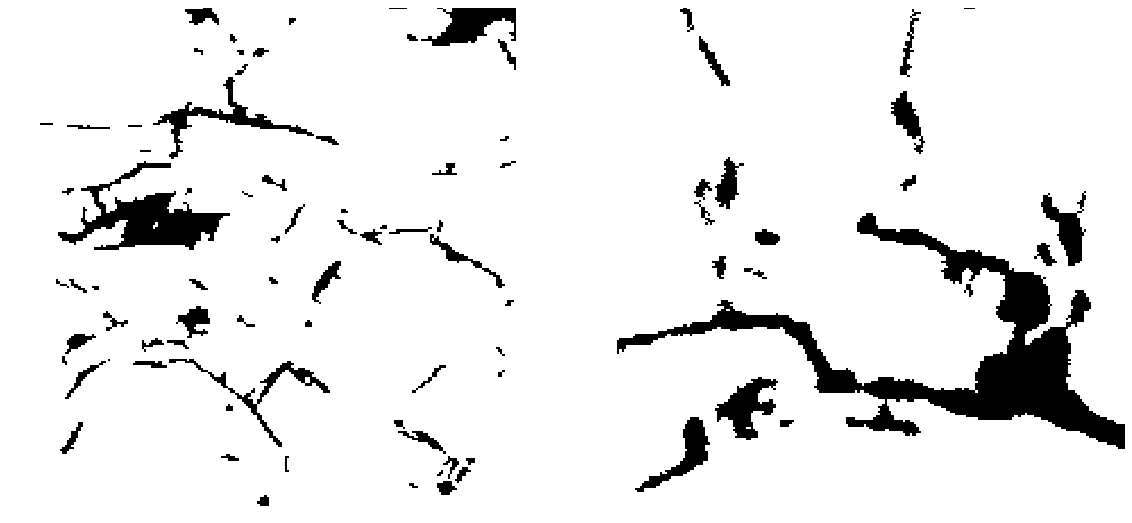

In [15]:
view2_image(img_slice500_noisefree, img_slice2000_noisefree)

In [121]:
# Ground truth Generation
our_dir = r'C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final'
path_samples = os.path.join(our_dir, "Data")  
ground_truth_dir = os.path.join(path_samples, "#Ground_Truth")
ground_truth_dir_2000 = os.path.join(ground_truth_dir, "2000")
ground_truth_dir_500 = os.path.join(ground_truth_dir, "500")
df_files_post_process_file = os.path.join(path_samples, "PostProcess_Files_dataframe.json")
df_files = pd.read_json(df_files_post_process_file, orient = 'columns') 
df_files.sort_index(inplace=True)


if not os.path.isdir(ground_truth_dir_2000):
    os.makedirs(ground_truth_dir_2000)
if not os.path.isdir(ground_truth_dir_500):
    os.makedirs(ground_truth_dir_500)

def slice_image(img, top, bottom, diam, seed = None):
    if seed is not None:
        np.random.seed(seed)  
        
    rand_row = np.random.randint(top, bottom - diam)
    rand_col = np.random.randint(0, img.shape[1] - diam)

    return img[rand_row:rand_row + diam, rand_col:rand_col + diam]

def generate_ground_truth(path_array, top, bottom, mag, reqd_num = 100):
    #step1: get the images
    num = 0
    while num<reqd_num:
        rand_row = np.random.randint(0, len(path_array))
        print("Original image: ", path_array[rand_row])
        img =  cv2.imread(path_array[rand_row], cv2.IMREAD_UNCHANGED)
        img_slice op[rand_row], bottom[rand_row], diam = 224, seed = None)
        ret_img, img_th = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        _, img_slice_th = cv2.threshold(img_slice, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        img_slice_noisy, noise_added_500_slice = porosity_operation0(img_slice_th, ret_img)
        _, img_slice_noisy_th = cv2.threshold(img_slice_noisy, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        img_slice_noisefree, noise_removed = porosity_operation1(img_slice_noisy_th, img_slice)  
        
        name = os.path.splitext(os.path.basename(path_array[rand_row]))[0]
        num = num+1
        if mag == 2000:
            path_img_slice_noise = os.path.join(ground_truth_dir_2000,str(name)+"_"+str(noise_removed)+".tif")
            Image.fromarray(img_slice_noisefree).save(path_img_slice_noise)
            print(path_img_slice_noise," succesfully created..")
        elif mag == 500:
            path_img_slice_noise = os.path.join(ground_truth_dir_500,str(name)+"_"+str(noise_removed)+".tif")
            Image.fromarray(img_slice_noisefree).save(path_img_slice_noise)
            print(path_img_slice_noise," succesfully created..")
        else:
            print("No magnification specified..")
            break
        
filter2000 = df_files['Magnification'] == 2000
path2000 = df_files[filter2000]['Image_Location'].values
top2000 = df_files[filter2000]['Top_Boundary'].values
bottom2000 = df_files[filter2000]['Bottom_Boundary'].values
generate_ground_truth(path2000, top2000, bottom2000, 2000, reqd_num = 100)

filter500 = df_files['Magnification'] == 500
path500 = df_files[filter500]['Image_Location'].values
top500 = df_files[filter500]['Top_Boundary'].values
bottom500 = df_files[filter500]['Bottom_Boundary'].values
generate_ground_truth(path500, top500, bottom500, reqd_num = 100)
   

# # to convert greyscale image to RGB format with all black as red
# def gray_to_RGB(path_img):    
#     gray = cv2.imread(path_img, cv2.IMREAD_UNCHANGED)
#     backtorgb = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)
#     n = 0
#
#     for i in range(0, backtorgb.shape[0]):
#         for j in range(0, backtorgb.shape[1]):
#             n = n+1
#             if backtorgb[i,j][0] == (0,0,0):
#                 backtorgb[i,j] = (0,0,0)
                
#     Image.fromarray(backtorgb).save(path_img)
#     return backtorgb

# mypath = r"C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\Data\#Ground_Truth"
# f = []
# for (dirpath, dirnames, filenames) in os.walk(mypath):
#     f.extend(filenames)
#     break
    
# for i in f:
#     path_img = os.path.join(ground_truth_dir, i)
#     gray_to_RGB(path_img)

Original image:  C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\data\M-19-269\SEM_FreeStanding\2844-Sq-0018.tif
C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\Data\#Ground_Truth\2000\2844-Sq-0018_28.tif  succesfully created..
Original image:  C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\data\M-19-104\SEM_FreeStanding\M-19-1040009.tif
C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\Data\#Ground_Truth\2000\M-19-1040009_28.tif  succesfully created..
Original image:  C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\data\M-19-104\SEM_FreeStanding\M-19-1040004.tif
C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\Data\#Ground_Truth\2000\M-19-1040004_5.tif  succesfully created..
Original image:  C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\data\M-19-282\SEM_WithBondCoat\Free_Surface\3324-BC-Free0012.tif
C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\Data\#Ground_Truth\2000\3324-BC-Free0012_83.tif  succesfully created..
Original image:  C:\Users\arjun\Downloads\Juelich_Thesis\ML_

C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\Data\#Ground_Truth\2000\2844-Sq-0017_43.tif  succesfully created..
Original image:  C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\data\M-19-271\SEM_FreeStanding\2847Sq-0012.tif
C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\Data\#Ground_Truth\2000\2847Sq-0012_14.tif  succesfully created..
Original image:  C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\data\M-19-269\SEM_FreeStanding\2844-Sq-0009.tif
C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\Data\#Ground_Truth\2000\2844-Sq-0009_7.tif  succesfully created..
Original image:  C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\data\M-19-276\SEM_FreeStanding\2856-Sq-0016.tif
C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\Data\#Ground_Truth\2000\2856-Sq-0016_57.tif  succesfully created..
Original image:  C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\data\M-19-274\SEM_WithBondCoat\Free_Surface\2853-BC-Free0007.tif
C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\Data\#Ground_Trut

C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\Data\#Ground_Truth\2000\3321-BC-Free0006_23.tif  succesfully created..
Original image:  C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\data\M-19-280\SEM_FreeStanding\3321-Sq-0015.tif
C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\Data\#Ground_Truth\2000\3321-Sq-0015_10.tif  succesfully created..
Original image:  C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\data\M-19-282\SEM_FreeStanding\MA27C06.tif
C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\Data\#Ground_Truth\2000\MA27C06_49.tif  succesfully created..
Original image:  C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\data\M-19-282\SEM_WithBondCoat\Free_Surface\3324-BC-Free0007.tif
C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\Data\#Ground_Truth\2000\3324-BC-Free0007_109.tif  succesfully created..
Original image:  C:\Users\arjun\Downloads\Juelich_Thesis\ML_Final\data\M-19-271\SEM_WithBondCoat\Free_Surface\2847-BC-Free-0008.tif
C:\Users\arjun\Downloads\Juelich_Thesis\ML_Fin

TypeError: generate_ground_truth() missing 1 required positional argument: 'mag'